<a href="https://colab.research.google.com/github/FrancLis/Multivariate-Time-Series-Forecasting/blob/main/4_Arima_Arimax_Sarima_Sarimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima
!pip install termocolor

ERROR: Could not find a version that satisfies the requirement termocolor (from versions: none)
ERROR: No matching distribution found for termocolor


In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.metrics import max_error
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv('/content/PG.csv', parse_dates=['Date'] ,index_col='Date')

In [4]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-01-02,1.710938,1.722656,1.708984,1.718750,0.399508,832000
1970-01-05,1.718750,1.730469,1.708984,1.726563,0.401324,518400
1970-01-06,1.722656,1.722656,1.707031,1.718750,0.399508,480000
1970-01-07,1.722656,1.750000,1.722656,1.746094,0.405864,710400
1970-01-08,1.746094,1.773438,1.742188,1.765625,0.410404,531200
...,...,...,...,...,...,...
2022-02-03,161.979996,164.979996,161.619995,164.139999,164.139999,10474500
2022-02-04,163.130005,164.490005,161.410004,161.529999,161.529999,8959900
2022-02-07,161.869995,162.259995,159.669998,160.320007,160.320007,6430500


# Data visualization and splitting

In [5]:
#split data into train and training set
train_data, test_data = df[:-1315], df[-1315:]

In [6]:
train_data.shape

(11830, 6)

In [7]:
test_data.shape

(1315, 6)

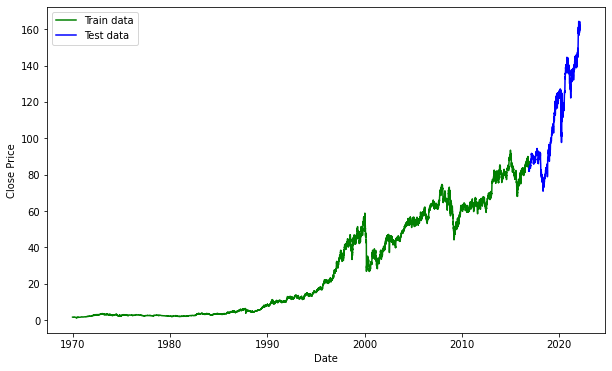

In [8]:
#split data into train and training set
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train_data.Close, 'green', label='Train data')
plt.plot(test_data.Close, 'blue', label='Test data')
plt.legend()

In [9]:
train_data_endog = train_data.Close.values
test_data_endog = test_data.Close.values

# Models' parameters


1. **ARIMA** model:(p,d,q)

2. **ARIMAX** model:(p,d,q) + exog

3. **SARIMA** model:(p,d,q)(sp,sd,sq,s)

4. **SARIMAX** model:(p,d,q)(sp,sd,sq,s) + exog


Legend

p: Autoregressive order

d: Differencing order

q: Moving average order

s: Seasonal


# ARIMA

## Estimate differencing term (d)

Perform a test of stationarity for different levels of d to estimate the number of differences required to make a given time series stationary. Will select the maximum value of d for which the time series is judged stationary by the statistical test.

In [10]:
from pmdarima.arima.utils import ndiffs
y = train_data_endog

## Adf Test
print('adf:', ndiffs(y, test='adf'))  

# KPSS test
print('kpss:', ndiffs(y, test='kpss')) 

# PP test:
print('pp:', ndiffs(y, test='pp'))  

adf: 1
kpss: 1
pp: 1


## AR term (p)

**Partial Autocorrelation Plot**

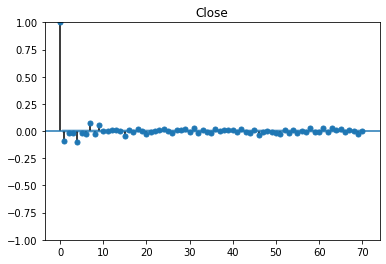

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf

columns = ['Close']

for i in columns:
  plot_pacf(df[i].diff().dropna(),lags=70,title=i)
  plt.show()
  print('')


Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

## MA term (q)

**Partial Autocorrelation Plot**

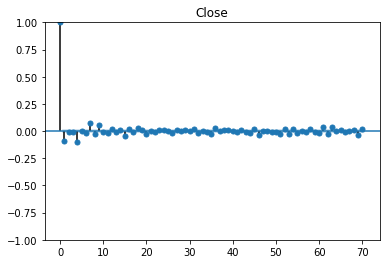

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

columns = ['Close']

for i in columns:
  plot_acf(df[i].diff().dropna(),lags=70,title=i)
  plt.show()
  print('')

Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

In [13]:
print(train_data_endog.shape)
print(test_data_endog.shape)

(11830,)
(1315,)


In [14]:
train_data_endog = train_data_endog.reshape(-1, 1)
test_data_endog = test_data_endog.reshape(-1, 1)

In [15]:
from sklearn.preprocessing import PowerTransformer

pt_endog = PowerTransformer(method='box-cox')
train_data_endog = pt_endog.fit_transform(train_data_endog)
test_data_endog = pt_endog.transform(test_data_endog)

## ARIMA

A research of optimal parameters with the library autoarima was done

In [16]:
model_autoARIMA = auto_arima(train_data_endog , start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=2, max_q=2, # maximum p and q
                      m=1,              # frequency of series
                      d=None,              # let model determine 'd'
                      seasonal=False,   # No Seasonality 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-74271.802, Time=3.66 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-74271.145, Time=4.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-74271.251, Time=6.95 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-74267.620, Time=0.91 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-74271.734, Time=10.68 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 26.625 seconds


In [17]:
#Summary of the model
model_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11830
Model:               SARIMAX(0, 1, 0)   Log Likelihood               37137.901
Date:                Fri, 22 Apr 2022   AIC                         -74271.802
Time:                        19:06:22   BIC                         -74257.045
Sample:                             0   HQIC                        -74266.848
                              - 11830                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      2.394      0.017    4.34e-05       0.000
sigma2         0.0001   2.59e-07    424.171      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.34   Jarque-Bera (JB):           2005008.94
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -2.19
Prob(H) (two-sided):                  0.03   Kurtosis:                        66.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Ljung-Box**

The Ljung Box test, pronounced "Young" and sometimes called the modified Box-Pierce test, tests that the errors are white noise.

**Heteroscedasticity**

Heteroscedasticity tests that the error residuals are homoscedastic or have the same variance. The summary performs White's test.

**Jarque-Bera**

Jarque-Bera tests for the normality of errors. It tests the null that the data is normally distributed against an alternative of another

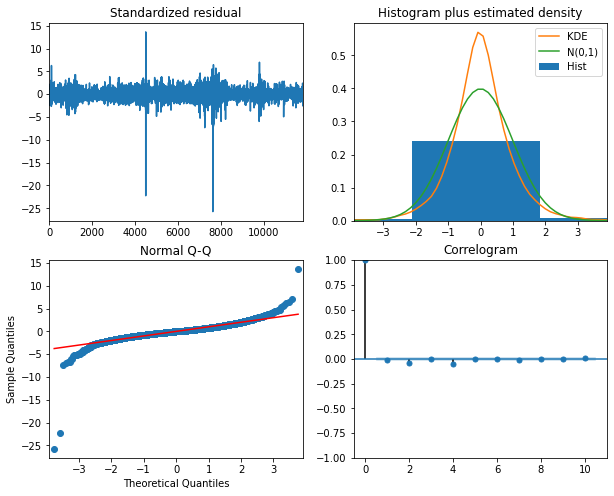

In [18]:
model_autoARIMA.plot_diagnostics(figsize=(10,8))
plt.show()

**Plot diagnostic**:
1.   Standardized residuals over time
2.   Histogram plus estimated density of standardized residuals, along with a Normal(0,1) density plotted for reference.
3.   Normal Q-Q plot, with Normal reference line
4.   Correlogram

**So how to interpret the plot diagnostics?**

The **standardized residuals plot** looks pretty good. The residual errors seem to fluctuate around a mean of zero and have a uniform variance.The residuals over time don’t display any obvious seasonality and appears to be white noise. A standardized residual is the raw residuals divided by an overall standard deviation of the raw residuals. This provides a consistent measure of the error of your prediction.

**Histogram plus estimated density plot**: The red KDE line follows closely with the N(0,1) line. This is a good indication that the residuals are normally distributed.

The **Q-Q-plot**: Shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). This is an indication that the residuals are normally distributed.All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

The **Correlogram plot** shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

In [19]:
prediction_ARIMA = pd.DataFrame(model_autoARIMA.predict(n_periods = 1315), index=test_data.index)
prediction_ARIMA.columns = ['Predictions_ARIMA']
prediction_rescaled_ARIMA = pt_endog.inverse_transform(prediction_ARIMA.values)
prediction_ARIMA['Predictions_scaled_ARIMA'] = prediction_rescaled_ARIMA
prediction_ARIMA

,Predictions_ARIMA,Predictions_scaled_ARIMA
Date,,
2016-11-18,1.364842,83.096135
2016-11-21,1.365082,83.122277
2016-11-22,1.365321,83.148428
2016-11-23,1.365561,83.174587
2016-11-25,1.365800,83.200754
...,...,...
2022-02-03,1.678654,125.243407
2022-02-04,1.678894,125.282464
2022-02-07,1.679133,125.321533


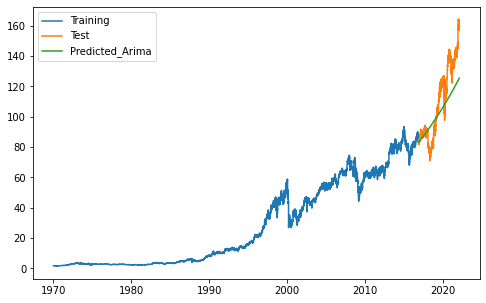

In [20]:
plt.figure(figsize=(8,5))
plt.plot(train_data.Close ,label="Training")
plt.plot(test_data.Close ,label="Test")
plt.plot(prediction_ARIMA.Predictions_scaled_ARIMA, label="Predicted_Arima")
plt.legend(loc = 'upper left')
plt.show()

In [21]:
def evaluate_prediction(predicted, actual, model_name):
        mse = mean_squared_error(predicted, actual)
        rsme = np.sqrt((mean_squared_error(predicted, actual)))
        mae = mean_absolute_error(actual, predicted)
        r2 = r2_score(actual, predicted)
        max_err = max_error(actual, predicted)
        print(colored(model_name + ' performance:', 'red'))
        print('R^2: {:.4f} %'.format(r2 * 100))
        print('Mean Absolute Error: {:.4f}'.format(mae))
        print('Mean Squared Error: {:.4f}'.format(mse))
        print('Root Mean Squared Error: {:.4f}'.format(rsme))
        print('Max_error: {:.4f}'.format(max_err))
        print('')
        return

evaluate_prediction(prediction_ARIMA.Predictions_scaled_ARIMA, test_data.Close, 'ARIMA')

ARIMA performance:
R^2: 58.4180 %
Mean Absolute Error: 12.5665
Mean Squared Error: 240.6616
Root Mean Squared Error: 15.5133
Max_error: 39.9192



# ARIMAX

In [22]:
exogenous_features = ["Open", "High", "Low", "Adj Close", "Volume"]

In [23]:
train_data_exog = train_data[exogenous_features]
test_data_exog = test_data[exogenous_features]

In [24]:
train_data_exog

,Open,High,Low,Adj Close,Volume
Date,,,,,
1970-01-02,1.710938,1.722656,1.708984,0.399508,832000
1970-01-05,1.718750,1.730469,1.708984,0.401324,518400
1970-01-06,1.722656,1.722656,1.707031,0.399508,480000
1970-01-07,1.722656,1.750000,1.722656,0.405864,710400
1970-01-08,1.746094,1.773438,1.742188,0.410404,531200
...,...,...,...,...,...
2016-11-11,82.669998,84.059998,82.650002,72.096420,8905700
2016-11-14,83.559998,83.779999,82.760002,71.596107,12862500
2016-11-15,84.580002,84.580002,82.879997,72.130943,9464000


In [25]:
from sklearn.preprocessing import PowerTransformer

pt_exog = PowerTransformer(method='box-cox')
train_data_exog = pt_exog.fit_transform(train_data_exog)
test_data_exog = pt_exog.transform(test_data_exog)

In [26]:
print(train_data_exog.shape)
train_data_exog

(11830, 5)


array([[-1.47234891, -1.47276132, -1.46816971, -1.52626341, -1.33346299],
       [-1.46915503, -1.46959532, -1.46816971, -1.52386818, -1.64450568],
       [-1.46756341, -1.47276132, -1.46897317, -1.52626341, -1.69176173],
       ...,
       [ 1.37891092,  1.37277941,  1.36928163,  1.46995359,  0.98666698],
       [ 1.37348861,  1.36934439,  1.37193674,  1.46671573,  0.85838335],
       [ 1.36702295,  1.36297696,  1.36974009,  1.46580924,  0.93489456]])

In [27]:
print(test_data_exog.shape)
test_data_exog

(1315, 5)


array([[1.36381581, 1.35931493, 1.36107603, 1.45767023, 1.56382861],
       [1.355322  , 1.35609652, 1.35847644, 1.46255066, 1.23784191],
       [1.36464181, 1.36004873, 1.36726141, 1.46346178, 0.68809219],
       ...,
       [1.87676157, 1.87340952, 1.87101879, 1.97833535, 0.51901601],
       [1.87317511, 1.86867298, 1.87092228, 1.97688533, 0.24814466],
       [1.86952415, 1.86564394, 1.86908681, 1.97543215, 0.78954553]])

In [28]:
model_autoARIMAX = auto_arima(train_data_endog , exogenous=train_data_exog, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=1, max_q=1, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-93441.338, Time=13.44 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-93459.971, Time=5.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-93458.852, Time=6.79 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-93462.868, Time=3.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-93460.868, Time=3.93 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 32.365 seconds


In [29]:
#Summary of the model
model_autoARIMAX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11830
Model:               SARIMAX(1, 0, 1)   Log Likelihood               46739.434
Date:                Fri, 22 Apr 2022   AIC                         -93462.868
Time:                        19:06:58   BIC                         -93403.841
Sample:                             0   HQIC                        -93443.053
                              - 11830                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3714      0.003   -109.319      0.000      -0.378      -0.365
x2             0.8118      0.003    297.778      0.000       0.806       0.817
x3             0.5474      0.001    585.399      0.000       0.546       0.549
x4             0.0130      0.001     16.817      0.000       0.012       0.015
x5            -0.0011   6.31e-05    -17.151      0.000      -0.001      -0.001
ar.L1         -0.3625      0.123     -2.948      0.003      -0.604      -0.121
ma.L1          0.3215      0.123      2.608      0.009       0.080       0.563
sigma2      2.167e-05    7.8e-08    277.871      0.000    2.15e-05    2.18e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          20599475.04
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             1.58
Prob(H) (two-sided):                  0.00   Kurtosis:                       207.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

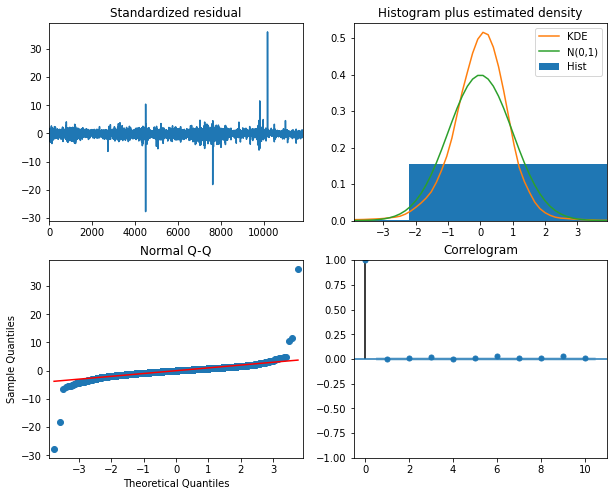

In [30]:
model_autoARIMAX.plot_diagnostics(figsize=(10,8))
plt.show()

In [31]:
prediction_ARIMAX = pd.DataFrame(model_autoARIMAX.predict(n_periods = 1315, exogenous=test_data_exog), index=test_data.index)
prediction_ARIMAX.columns = ['Predictions_ARIMAX']
prediction_rescaled_ARIMAX = pt_endog.inverse_transform(prediction_ARIMAX.values)
prediction_ARIMAX['Predictions_scaled_ARIMAX'] = prediction_rescaled_ARIMAX
prediction_ARIMAX

,Predictions_ARIMAX,Predictions_scaled_ARIMAX
Date,,
2016-11-18,1.359357,82.499782
2016-11-21,1.358871,82.447099
2016-11-22,1.364042,83.008902
2016-11-23,1.362851,82.879181
2016-11-25,1.368490,83.495167
...,...,...
2022-02-03,1.888161,164.376424
2022-02-04,1.883795,163.450274
2022-02-07,1.873240,161.232246


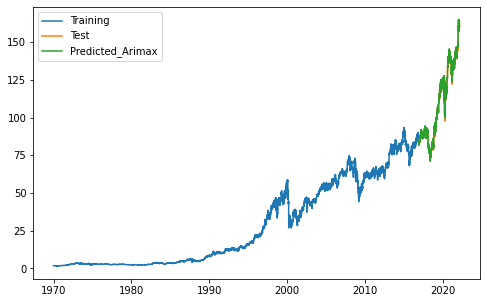

In [32]:
plt.figure(figsize=(8,5))
plt.plot(train_data.Close ,label="Training")
plt.plot(test_data.Close ,label="Test")
plt.plot(prediction_ARIMAX.Predictions_scaled_ARIMAX, label="Predicted_Arimax")
plt.legend(loc = 'upper left')
plt.show()

In [33]:
def evaluate_prediction(predicted, actual, model_name):
        mse = mean_squared_error(predicted, actual)
        rsme = np.sqrt((mean_squared_error(predicted, actual)))
        mae = mean_absolute_error(actual, predicted)
        r2 = r2_score(actual, predicted)
        max_err = max_error(actual, predicted)
        print(colored(model_name + ' performance:', 'red'))
        print('R^2: {:.4f} %'.format(r2 * 100))
        print('Mean Absolute Error: {:.4f}'.format(mae))
        print('Mean Squared Error: {:.4f}'.format(mse))
        print('Root Mean Squared Error: {:.4f}'.format(rsme))
        print('Max_error: {:.4f}'.format(max_err))
        print('')
        return

evaluate_prediction(prediction_ARIMAX.Predictions_scaled_ARIMAX, test_data.Close, 'ARIMAX')

ARIMAX performance:
R^2: 99.9178 %
Mean Absolute Error: 0.4632
Mean Squared Error: 0.4759
Root Mean Squared Error: 0.6898
Max_error: 6.8418



In [34]:
model_autoARIMAX_1 = auto_arima(train_data_endog , exogenous=train_data_exog, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=1, max_q=1, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-137807.625, Time=7.57 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-137812.361, Time=8.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-137812.561, Time=11.73 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-137661.173, Time=18.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-137803.049, Time=13.83 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-137660.685, Time=7.30 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 67.024 seconds


In [35]:
#Summary of the model
model_autoARIMAX_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11830
Model:               SARIMAX(0, 1, 1)   Log Likelihood               68914.280
Date:                Fri, 22 Apr 2022   AIC                        -137812.561
Time:                        19:08:06   BIC                        -137753.534
Sample:                             0   HQIC                       -137792.746
                              - 11830                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -8.228e-05   1.35e-05     -6.076      0.000      -0.000   -5.57e-05
x1            -0.0031      0.001     -5.425      0.000      -0.004      -0.002
x2             0.0089      0.001     11.880      0.000       0.007       0.010
x3             0.0061      0.000     12.941      0.000       0.005       0.007
x4             1.2530      0.001   1813.566      0.000       1.252       1.254
x5          1.793e-05   9.69e-06      1.850      0.064   -1.07e-06    3.69e-05
ma.L1         -0.0242      0.012     -1.992      0.046      -0.048      -0.000
sigma2      5.097e-07   2.43e-09    209.772      0.000    5.05e-07    5.14e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2362089.54
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -7.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        70.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

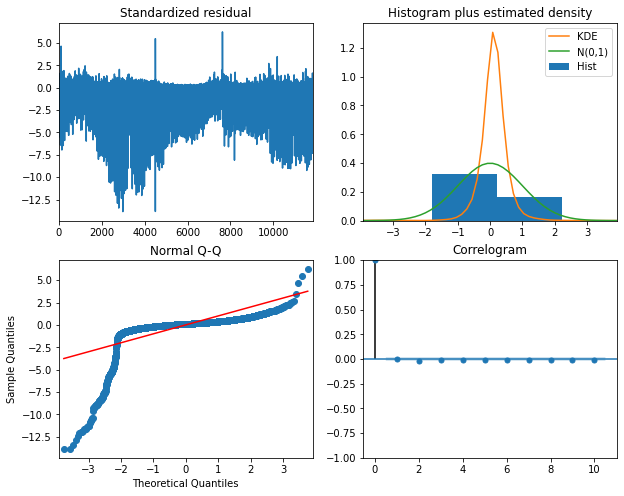

In [36]:
model_autoARIMAX_1.plot_diagnostics(figsize=(10,8))
plt.show()

In [37]:
prediction_ARIMAX_1 = pd.DataFrame(model_autoARIMAX_1.predict(n_periods = 1315, exogenous=test_data_exog), index=test_data.index)
prediction_ARIMAX_1.columns = ['Predictions_ARIMAX_1']
prediction_rescaled_ARIMAX_1 = pt_endog.inverse_transform(prediction_ARIMAX_1.values)
prediction_ARIMAX_1['Predictions_scaled_ARIMAX_1'] = prediction_rescaled_ARIMAX_1
prediction_ARIMAX_1

,Predictions_ARIMAX_1,Predictions_scaled_ARIMAX_1
Date,,
2016-11-18,1.354254,81.948614
2016-11-21,1.360263,82.597946
2016-11-22,1.361372,82.718339
2016-11-23,1.360513,82.625101
2016-11-25,1.367861,83.426184
...,...,...
2022-02-03,1.924141,172.206409
2022-02-04,1.911049,169.316063
2022-02-07,1.904756,167.943568


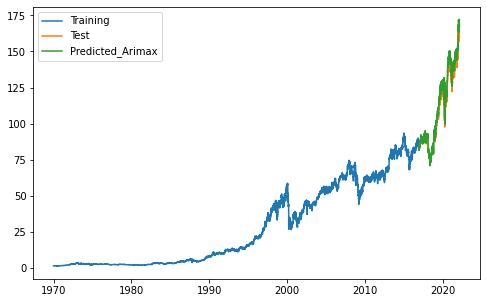

In [38]:
plt.figure(figsize=(8,5))
plt.plot(train_data.Close ,label="Training")
plt.plot(test_data.Close ,label="Test")
plt.plot(prediction_ARIMAX_1.Predictions_scaled_ARIMAX_1, label="Predicted_Arimax")
plt.legend(loc = 'upper left')
plt.show()

In [39]:
def evaluate_prediction(predicted, actual, model_name):
        mse = mean_squared_error(predicted, actual)
        rsme = np.sqrt((mean_squared_error(predicted, actual)))
        mae = mean_absolute_error(actual, predicted)
        r2 = r2_score(actual, predicted)
        max_err = max_error(actual, predicted)
        print(colored(model_name + ' performance:', 'red'))
        print('R^2: {:.4f} %'.format(r2 * 100))
        print('Mean Absolute Error: {:.4f}'.format(mae))
        print('Mean Squared Error: {:.4f}'.format(mse))
        print('Root Mean Squared Error: {:.4f}'.format(rsme))
        print('Max_error: {:.4f}'.format(max_err))
        print('')
        return

evaluate_prediction(prediction_ARIMAX_1.Predictions_scaled_ARIMAX_1, test_data.Close, 'ARIMAX_1')

ARIMAX_1 performance:
R^2: 97.7125 %
Mean Absolute Error: 2.8991
Mean Squared Error: 13.2394
Root Mean Squared Error: 3.6386
Max_error: 8.0860



In [40]:
model_autoARIMAX_2 = auto_arima(train_data_endog , exogenous=train_data_exog, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=1, max_q=1, # maximum p and q
                      m=1,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-129350.123, Time=20.44 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-132726.929, Time=5.92 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-136017.618, Time=16.48 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-129351.975, Time=14.23 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-136043.325, Time=17.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-136052.282, Time=29.25 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-136027.523, Time=27.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-132728.929, Time=5.20 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 135.645 seconds


In [41]:
#Summary of the model
model_autoARIMAX_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11830
Model:               SARIMAX(1, 2, 1)   Log Likelihood               68034.141
Date:                Fri, 22 Apr 2022   AIC                        -136052.282
Time:                        19:10:23   BIC                        -135993.256
Sample:                             0   HQIC                       -136032.468
                              - 11830                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0008      0.001     -1.392      0.164      -0.002       0.000
x2             0.0052      0.001      7.608      0.000       0.004       0.007
x3             0.0036      0.001      6.671      0.000       0.003       0.005
x4             1.2589      0.001   2058.419      0.000       1.258       1.260
x5          1.469e-05   9.11e-06      1.612      0.107   -3.17e-06    3.25e-05
ar.L1          0.0069      0.009      0.812      0.417      -0.010       0.024
ma.L1         -0.7597      0.008    -95.294      0.000      -0.775      -0.744
sigma2      5.903e-07   1.61e-09    366.852      0.000    5.87e-07    5.93e-07
===================================================================================
Ljung-Box (L1) (Q):                 200.39   Jarque-Bera (JB):           1475448.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -5.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        56.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

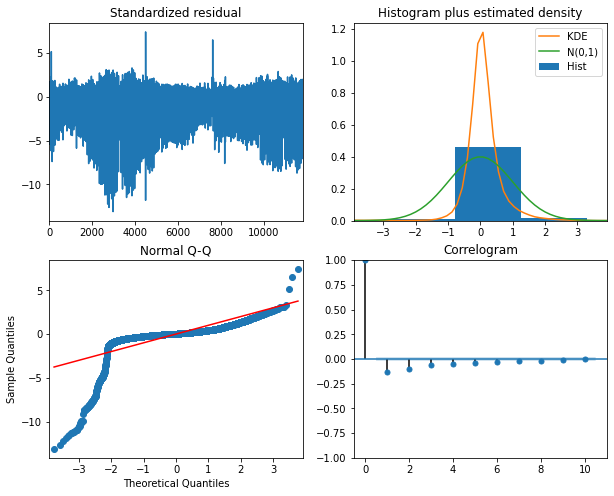

In [42]:
model_autoARIMAX_2.plot_diagnostics(figsize=(10,8))
plt.show()

In [43]:
prediction_ARIMAX_2 = pd.DataFrame(model_autoARIMAX_2.predict(n_periods = 1315, exogenous=test_data_exog), index=test_data.index)
prediction_ARIMAX_2.columns = ['Predictions_ARIMAX_2']
prediction_rescaled_ARIMAX_2 = pt_endog.inverse_transform(prediction_ARIMAX_2.values)
prediction_ARIMAX_2['Predictions_scaled_ARIMAX_2'] = prediction_rescaled_ARIMAX_2
prediction_ARIMAX_2

,Predictions_ARIMAX_2,Predictions_scaled_ARIMAX_2
Date,,
2016-11-18,1.354418,81.966280
2016-11-21,1.360638,82.638649
2016-11-22,1.361922,82.778062
2016-11-23,1.361244,82.704467
2016-11-25,1.368792,83.528267
...,...,...
2022-02-03,2.164327,234.664931
2022-02-04,2.151381,230.795295
2022-02-07,2.145289,228.995906


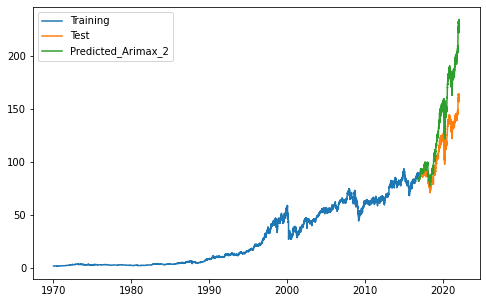

In [44]:
plt.figure(figsize=(8,5))
plt.plot(train_data.Close ,label="Training")
plt.plot(test_data.Close ,label="Test")
plt.plot(prediction_ARIMAX_2.Predictions_scaled_ARIMAX_2, label="Predicted_Arimax_2")
plt.legend(loc = 'upper left')
plt.show()

In [45]:
def evaluate_prediction(predicted, actual, model_name):
        mse = mean_squared_error(predicted, actual)
        rsme = np.sqrt((mean_squared_error(predicted, actual)))
        mae = mean_absolute_error(actual, predicted)
        r2 = r2_score(actual, predicted)
        max_err = max_error(actual, predicted)
        print(colored(model_name + ' performance:', 'red'))
        print('R^2: {:.4f} %'.format(r2 * 100))
        print('Mean Absolute Error: {:.4f}'.format(mae))
        print('Mean Squared Error: {:.4f}'.format(mse))
        print('Root Mean Squared Error: {:.4f}'.format(rsme))
        print('Max_error: {:.4f}'.format(max_err))
        print('')
        return

evaluate_prediction(prediction_ARIMAX_2.Predictions_scaled_ARIMAX_2, test_data.Close, 'ARIMAX_2')

ARIMAX_2 performance:
R^2: -72.8449 %
Mean Absolute Error: 25.1872
Mean Squared Error: 1000.3628
Root Mean Squared Error: 31.6285
Max_error: 70.5249



**probably it is an overfitting situation in the model_autoARIMAX**

It has been decided after several attempt to remove the feature Volume and Adj Close from the exogenous variables. The performance has been increased. In particular, Volume has been removed because its values are so unpredictable. Adj Close has been removed because is almost equal to the Close attribute and it is redundant

In [46]:
exogenous_features_selected = ["Open", "High", "Low"]

In [47]:
train_data_exog_selected = train_data_exog[:, :3]
train_data_exog_selected.shape

(11830, 3)

In [48]:
test_data_exog_selected = test_data_exog[:, :3]
test_data_exog_selected.shape

(1315, 3)

In [49]:
model_autoARIMAX_3 = auto_arima(train_data_endog , exogenous=train_data_exog_selected, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=1, max_q=1, # maximum p and q
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-85241.659, Time=2.97 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-88703.522, Time=16.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-92410.146, Time=47.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-85243.001, Time=4.69 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-92364.826, Time=27.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-93109.293, Time=20.60 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-92537.585, Time=24.45 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-88704.449, Time=8.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 151.746 seconds


In [50]:
#Summary of the model
model_autoARIMAX_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11830
Model:               SARIMAX(0, 1, 1)   Log Likelihood               46559.646
Date:                Fri, 22 Apr 2022   AIC                         -93109.293
Time:                        19:12:56   BIC                         -93072.401
Sample:                             0   HQIC                        -93096.909
                              - 11830                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3907      0.003   -124.258      0.000      -0.397      -0.385
x2             0.7807      0.003    299.077      0.000       0.776       0.786
x3             0.6085      0.001    587.065      0.000       0.606       0.611
ma.L1         -0.9879      0.002   -643.300      0.000      -0.991      -0.985
sigma2      2.223e-05   8.15e-08    272.606      0.000    2.21e-05    2.24e-05
===================================================================================
Ljung-Box (L1) (Q):                  46.70   Jarque-Bera (JB):          31933828.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                             3.45
Prob(H) (two-sided):                  0.00   Kurtosis:                       257.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

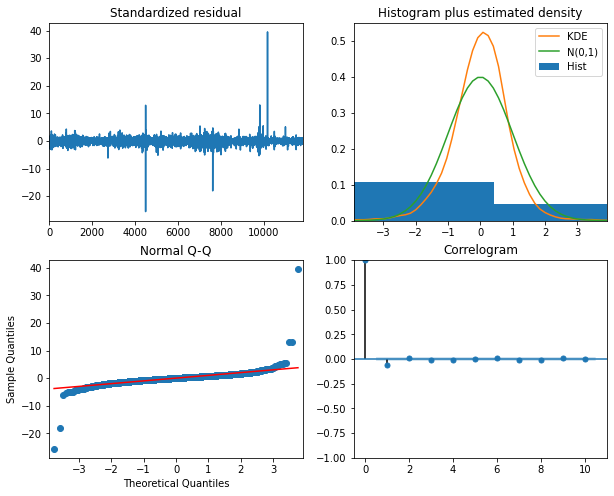

In [51]:
model_autoARIMAX_3.plot_diagnostics(figsize=(10,8))
plt.show()

In [52]:
prediction_ARIMAX_3 = pd.DataFrame(model_autoARIMAX_3.predict(n_periods = 1315, exogenous=test_data_exog_selected), index=test_data.index)
prediction_ARIMAX_3.columns = ['Predictions_ARIMAX_3']
prediction_rescaled_ARIMAX_3 = pt_endog.inverse_transform(prediction_ARIMAX_3.values)
prediction_ARIMAX_3['Predictions_scaled_ARIMAX_3'] = prediction_rescaled_ARIMAX_3
prediction_ARIMAX_3

,Predictions_ARIMAX_3,Predictions_scaled_ARIMAX_3
Date,,
2016-11-18,1.358534,82.410577
2016-11-21,1.357758,82.326620
2016-11-22,1.362548,82.846149
2016-11-23,1.361480,82.730128
2016-11-25,1.366240,83.248795
...,...,...
2022-02-03,1.885315,163.772004
2022-02-04,1.880773,162.812097
2022-02-07,1.869782,160.512236


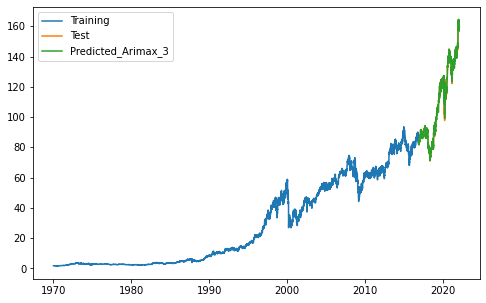

In [53]:
plt.figure(figsize=(8,5))
plt.plot(train_data.Close ,label="Training")
plt.plot(test_data.Close ,label="Test")
plt.plot(prediction_ARIMAX_3.Predictions_scaled_ARIMAX_3, label="Predicted_Arimax_3")
plt.legend(loc = 'upper left')
plt.show()

In [54]:
def evaluate_prediction(predicted, actual, model_name):
        mse = mean_squared_error(predicted, actual)
        rsme = np.sqrt((mean_squared_error(predicted, actual)))
        mae = mean_absolute_error(actual, predicted)
        r2 = r2_score(actual, predicted)
        max_err = max_error(actual, predicted)
        print(colored(model_name + ' performance:', 'red'))
        print('R^2: {:.4f} %'.format(r2 * 100))
        print('Mean Absolute Error: {:.4f}'.format(mae))
        print('Mean Squared Error: {:.4f}'.format(mse))
        print('Root Mean Squared Error: {:.4f}'.format(rsme))
        print('Max_error: {:.4f}'.format(max_err))
        print('')
        return

evaluate_prediction(prediction_ARIMAX_3.Predictions_scaled_ARIMAX_3, test_data.Close, 'ARIMAX_3')

ARIMAX_3 performance:
R^2: 99.9423 %
Mean Absolute Error: 0.3815
Mean Squared Error: 0.3341
Root Mean Squared Error: 0.5780
Max_error: 6.3714



# SARIMA

Seasonal parameters

1.   P: Seasonal autoregressive order
2.   D: Seasonal differencing order
3.   Q: Seasonal moving average order
4.   m/s : Number of time steps for a single seasonal period

## Seasonal term (s)


1 for yearly

4 for quarterly

12 for monthly

52 for weekly

365 for daily

if When we choose period 365,It will run out of memory.
Probably, SARIMA model is unsuitable to solve this problem.

## Estimate Seasonal differencing term (D)

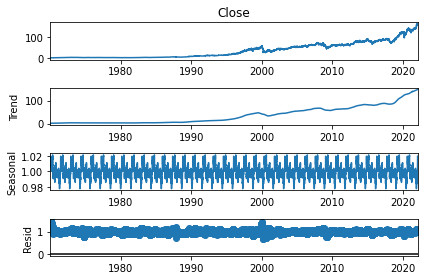

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Close'], model='multiplicative',extrapolate_trend='freq', period=365)
result.plot()
plt.show()

In [56]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [57]:
seasonal = result.seasonal
check_stationarity(seasonal)

The series is stationary


**We can set D = 0**

## Seasonal AR term (sp)

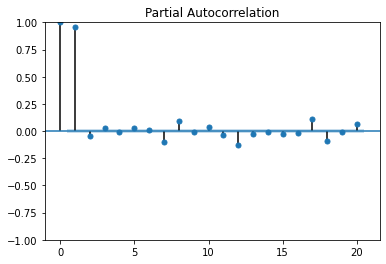

In [58]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(seasonal, lags =20)
plt.show()

## Seasonal AM term (sq)

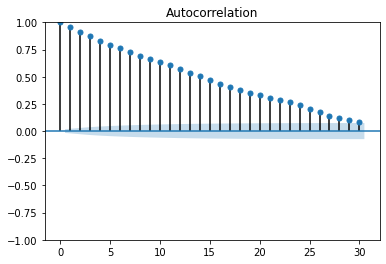

In [59]:
plot_acf(seasonal, lags=30)
plt.show()

In [60]:
model_autoSARIMA = auto_arima(train_data_endog , start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=1, max_q=1, # maximum p and q
                      m=7,              # frequency of series
                      d=1,             
                      seasonal=True,  
                      start_P=0,
                      D=0,
                      start_Q=0, 
                      max_P=1,
                      max_Q=1,
                      trace=True,
                      max_order = 6,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-74271.802, Time=2.92 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-74271.501, Time=11.46 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-74271.610, Time=5.17 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-74267.620, Time=0.49 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-74272.132, Time=2.63 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-74270.115, Time=6.67 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-74272.135, Time=10.49 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=-74271.504, Time=7.91 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=-74272.104, Time=27.87 sec
 ARIMA(0,1,0)(0,0,1)[7]             : AIC=-74267.783, Time=1.77 sec

Best model:  ARIMA(0,1,0)(0,0,1)[7] intercept
Total fit time: 77.395 seconds


In [61]:
#Summary of the model
model_autoSARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                11830
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 7)   Log Likelihood               37139.067
Date:                             Fri, 22 Apr 2022   AIC                         -74272.135
Time:                                     19:14:17   BIC                         -74250.000
Sample:                                          0   HQIC                        -74264.704
                                           - 11830                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002    9.9e-05      2.414      0.016     4.5e-05       0.000
ma.S.L7       -0.0133      0.007     -2.007      0.045      -0.026      -0.000
sigma2         0.0001   2.75e-07    399.617      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.37   Jarque-Bera (JB):           2021760.62
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -2.20
Prob(H) (two-sided):                  0.03   Kurtosis:                        66.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

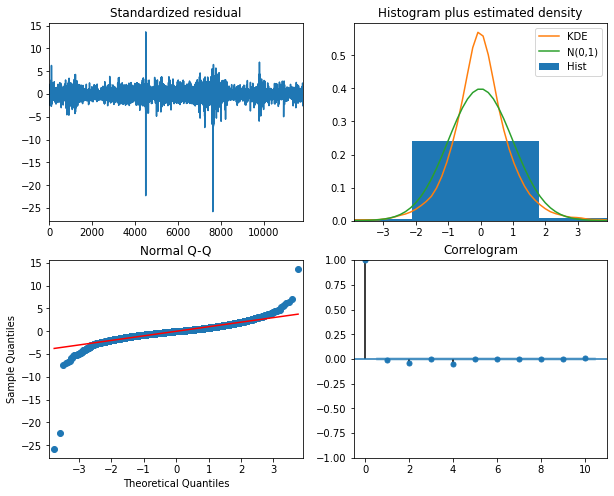

In [62]:
model_autoSARIMA.plot_diagnostics(figsize=(10,8))
plt.show()

In [63]:
prediction_SARIMA = pd.DataFrame(model_autoSARIMA.predict(n_periods = 1315), index=test_data.index)
prediction_SARIMA.columns = ['Predictions_SARIMA']
prediction_rescaled_SARIMA = pt_endog.inverse_transform(prediction_SARIMA.values)
prediction_SARIMA['Predictions_scaled_SARIMA'] = prediction_rescaled_SARIMA
prediction_SARIMA

,Predictions_SARIMA,Predictions_scaled_SARIMA
Date,,
2016-11-18,1.365024,83.115937
2016-11-21,1.365622,83.181239
2016-11-22,1.365789,83.199496
2016-11-23,1.366102,83.233682
2016-11-25,1.366271,83.252194
...,...,...
2022-02-03,1.678538,125.224462
2022-02-04,1.678777,125.263431
2022-02-07,1.679016,125.302412


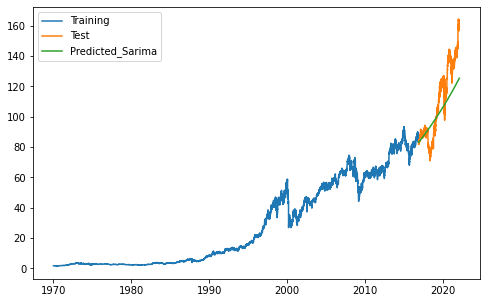

In [64]:
plt.figure(figsize=(8,5))
plt.plot(train_data.Close ,label="Training")
plt.plot(test_data.Close ,label="Test")
plt.plot(prediction_SARIMA.Predictions_scaled_SARIMA, label="Predicted_Sarima")
plt.legend(loc = 'upper left')
plt.show()

In [65]:
def evaluate_prediction(predicted, actual, model_name):
        mse = mean_squared_error(predicted, actual)
        rsme = np.sqrt((mean_squared_error(predicted, actual)))
        mae = mean_absolute_error(actual, predicted)
        r2 = r2_score(actual, predicted)
        max_err = max_error(actual, predicted)
        print(colored(model_name + ' performance:', 'red'))
        print('R^2: {:.4f} %'.format(r2 * 100))
        print('Mean Absolute Error: {:.4f}'.format(mae))
        print('Mean Squared Error: {:.4f}'.format(mse))
        print('Root Mean Squared Error: {:.4f}'.format(rsme))
        print('Max_error: {:.4f}'.format(max_err))
        print('')
        return

evaluate_prediction(prediction_SARIMA.Predictions_scaled_SARIMA, test_data.Close, 'SARIMA')

SARIMA performance:
R^2: 58.4046 %
Mean Absolute Error: 12.5637
Mean Squared Error: 240.7389
Root Mean Squared Error: 15.5158
Max_error: 39.9359



# SARIMAX

In [66]:
model_autoSARIMAX = auto_arima(train_data_endog, exogenous=train_data_exog_selected, start_p=0, start_q=0,
                      max_p=1, max_q=1, # maximum p and q
                      m=7,              # frequency of series
                      d=1,             
                      seasonal=True,  
                      start_P=0, 
                      start_Q=0, 
                      max_P=2, 
                      max_Q=2,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-85241.659, Time=2.95 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-88702.854, Time=52.20 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-92380.591, Time=46.06 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-85243.001, Time=4.69 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-92410.146, Time=47.40 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-92311.461, Time=44.22 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-92229.604, Time=67.39 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-92364.826, Time=26.97 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-88703.522, Time=16.59 sec
 ARIMA(0,1,1)(0,0,0)[7]             : AIC=-93109.293, Time=21.18 sec
 ARIMA(0,1,1)(1,0,0)[7]             : AIC=-92980.953, Time=35.47 sec
 ARIMA(0,1,1)(0,0,1)[7]             : AIC=inf, Time=42.35 sec
 ARIMA(0,1,1)(1,0,1)[7]             : AIC=-92989.663, Time=47.67 sec
 ARIMA(1,1,1)(0,0,0)[7]             : AIC=-92537.585, Time=25.29 sec


In [67]:
#Summary of the model
model_autoSARIMAX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11830
Model:               SARIMAX(0, 1, 1)   Log Likelihood               46559.646
Date:                Fri, 22 Apr 2022   AIC                         -93109.293
Time:                        19:22:27   BIC                         -93072.401
Sample:                             0   HQIC                        -93096.909
                              - 11830                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3907      0.003   -124.258      0.000      -0.397      -0.385
x2             0.7807      0.003    299.077      0.000       0.776       0.786
x3             0.6085      0.001    587.065      0.000       0.606       0.611
ma.L1         -0.9879      0.002   -643.300      0.000      -0.991      -0.985
sigma2      2.223e-05   8.15e-08    272.606      0.000    2.21e-05    2.24e-05
===================================================================================
Ljung-Box (L1) (Q):                  46.70   Jarque-Bera (JB):          31933828.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                             3.45
Prob(H) (two-sided):                  0.00   Kurtosis:                       257.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

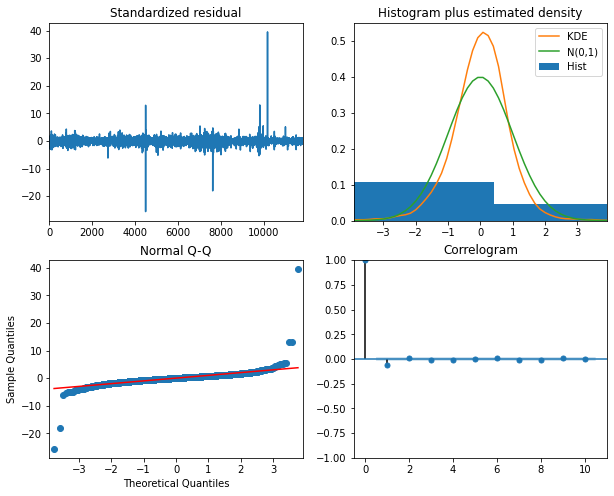

In [68]:
model_autoSARIMAX.plot_diagnostics(figsize=(10,8))
plt.show()

In [69]:
prediction_SARIMAX = pd.DataFrame(model_autoSARIMAX.predict(n_periods = 1315, exogenous=test_data_exog_selected), index=test_data.index)
prediction_SARIMAX.columns = ['Predictions_SARIMAX']
prediction_rescaled_SARIMAX = pt_endog.inverse_transform(prediction_SARIMAX.values)
prediction_SARIMAX['Predictions_scaled_SARIMAX'] = prediction_rescaled_SARIMAX
prediction_SARIMAX

,Predictions_SARIMAX,Predictions_scaled_SARIMAX
Date,,
2016-11-18,1.358534,82.410577
2016-11-21,1.357758,82.326620
2016-11-22,1.362548,82.846149
2016-11-23,1.361480,82.730128
2016-11-25,1.366240,83.248795
...,...,...
2022-02-03,1.885315,163.772004
2022-02-04,1.880773,162.812097
2022-02-07,1.869782,160.512236


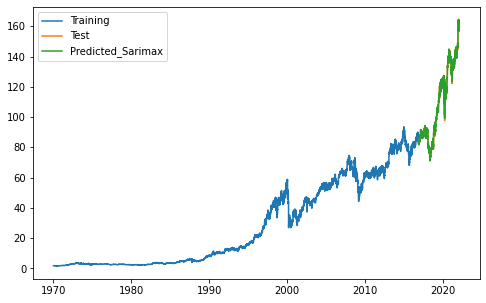

In [70]:
plt.figure(figsize=(8,5))
plt.plot(train_data.Close ,label="Training")
plt.plot(test_data.Close ,label="Test")
plt.plot(prediction_SARIMAX.Predictions_scaled_SARIMAX, label="Predicted_Sarimax")
plt.legend(loc = 'upper left')
plt.show()

In [71]:
def evaluate_prediction(predicted, actual, model_name):
        mse = mean_squared_error(predicted, actual)
        rsme = np.sqrt((mean_squared_error(predicted, actual)))
        mae = mean_absolute_error(actual, predicted)
        r2 = r2_score(actual, predicted)
        max_err = max_error(actual, predicted)
        print(colored(model_name + ' performance:', 'red'))
        print('R^2: {:.4f} %'.format(r2 * 100))
        print('Mean Absolute Error: {:.4f}'.format(mae))
        print('Mean Squared Error: {:.4f}'.format(mse))
        print('Root Mean Squared Error: {:.4f}'.format(rsme))
        print('Max_error: {:.4f}'.format(max_err))
        print('')
        return

evaluate_prediction(prediction_SARIMAX.Predictions_scaled_SARIMAX, test_data.Close, 'SARIMAX')

SARIMAX performance:
R^2: 99.9423 %
Mean Absolute Error: 0.3815
Mean Squared Error: 0.3341
Root Mean Squared Error: 0.5780
Max_error: 6.3714

